# Google Earth Engine para adquisición de datos del territorio en las parcelas de RecForest

Se elaborará un script por el cual mediante las coordenadas de las diferentes parcelas se obtendrá un modelo digital de elevaciones, temperatura del suelo (MODIS), serie de temperaturas verano vs invierno e información relevante sobre el suelo (bases de datos de interpolación y machine learning)

In [1]:
import ee

# Iniciamos Earth Engine
ee.Initialize(project = 'ee-danielfv2208')
ee.Authenticate()

True

Definimos el punto con las coordenadas que queremos: 

In [2]:
# Coordenadas y cargamos el punto
u_lon = -5.82441
u_lat = 40.10575
        # Aquí es pironal
Parcela = "Piornal"
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Por tema de la temperatura, vamos a establecer el incio del invierno y verano:
verano_inicio = '2023-06-21'
verano_fin = '2023-09-22'
invierno_inicio = '2023-12-21'
invierno_fin = '2024-03-19'

Vamos a cargar los distintos datasets para empezar: 

In [3]:
# Importamos la colección MODIS de LandCover.
lc = ee.ImageCollection('MODIS/061/MCD12Q1')

# Cargar la colección de CORINE Land Cover
corine = ee.ImageCollection('COPERNICUS/CORINE/V20/100m').select('landcover').first()

# Importar la colección MODIS para la temperatura del suelo
lst = ee.ImageCollection('MODIS/061/MOD11A1').select(['LST_Day_1km', 'LST_Night_1km'])
# Filtrar la colección para verano
lst_verano = lst.filterDate(verano_inicio, verano_fin).mean()
# Filtrar la colección para invierno
lst_invierno = lst.filterDate(invierno_inicio, invierno_fin).mean()
# Convertir a Celsius y calcular estadísticas
def kelvin_to_celsius(img):
    day = img.select('LST_Day_1km').multiply(0.02).subtract(273.15)
    night = img.select('LST_Night_1km').multiply(0.02).subtract(273.15)
    return day.addBands(night).copyProperties(img, ["system:time_start"])


# Importamos el MDT mundial.
elv = ee.Image('USGS/SRTMGL1_003')

# Calcular la pendiente
slope = ee.Terrain.slope(elv)

# Cargar el dataset de áreas protegidas WDPA
wdpa = ee.FeatureCollection('WCMC/WDPA/current/polygons')

# Cargar la imagen de pH del suelo
ph_image = ee.Image('OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02').select('b10')

# Cargar la colección de precipitación CHIRPS
chirps_collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate("2023-01-01", "2023-12-01") \
    .select('precipitation')

## Información genérica de la zona

In [4]:
scale = 1000  # escala en metros

# Altitud en el punto
elv_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print(f'Altitud en {Parcela}:', elv_point, 'm')

# Muestra la pendiente media en el punto de interés
import math
slope_value_degrees = slope.sample(u_poi, 10).first().get('slope').getInfo()
slope_value_percent = round(math.tan(math.radians(slope_value_degrees)) * 100, 1)
print(f'La pendiente media en {Parcela} es:', slope_value_percent, '%')

# Muestra el valor de pH en el punto especificado
ph_point = ph_image.sample(u_poi, scale=100).first().get('b10').getInfo()
# Imprimir el valor de pH del suelo
print(f'Valor de pH del suelo en {Parcela}:', ph_point / 10)

# Calcula la temperatura del suelo.---------------------------------------------------
#lst_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
#print('Temperatura del suelo media en el punto:', round(lst_point*0.02 -273.15, 2), '°C')
lst_celsius = lst.map(kelvin_to_celsius)
# Calcular la media, máxima y mínima de la temperatura diurna y nocturna en el punto
lst_stats = lst_celsius.reduce(ee.Reducer.mean().combine(
    reducer2=ee.Reducer.max(),
    sharedInputs=True).combine(
    reducer2=ee.Reducer.min(),
    sharedInputs=True))
# Muestra las estadísticas en el punto
stats_point = lst_stats.sample(u_poi, scale).first().getInfo()
# Extraer y mostrar las estadísticas
lst_day_mean = stats_point['properties']['LST_Day_1km_mean']
lst_day_max = stats_point['properties']['LST_Day_1km_max']
lst_night_min = stats_point['properties']['LST_Night_1km_min']
print(f'Temperatura del suelo media diurna en {Parcela}:', round(lst_day_mean, 2), '°C')
print(f'Temperatura del suelo máxima diurna en {Parcela}:', round(lst_day_max, 2), '°C')
print(f'Temperatura del suelo mínima nocturna en {Parcela}:', round(lst_night_min, 2), '°C')
# Filtrar la colección para verano e invierno
lst_verano = lst_celsius.filterDate(verano_inicio, verano_fin)
lst_invierno = lst_celsius.filterDate(invierno_inicio, invierno_fin)
# Calcular la temperatura media en el punto para verano e invierno
def calculate_mean_temperature(collection, point, scale):
    mean_image = collection.mean()
    stats = mean_image.reduceRegion(ee.Reducer.mean(), point, scale).getInfo()
    day_temp = stats['LST_Day_1km']
    night_temp = stats['LST_Night_1km']
    return (day_temp + night_temp) / 2
# Temperatura media total en verano
temperatura_verano = calculate_mean_temperature(lst_verano, u_poi, scale)
# Temperatura media total en invierno
temperatura_invierno = calculate_mean_temperature(lst_invierno, u_poi, scale)
print(f'Temperatura del suelo media total en verano en {Parcela}:', round(temperatura_verano, 2), '°C')
print(f'Temperatura del suelo media total en invierno en {Parcela}:', round(temperatura_invierno, 2), '°C')
#--------------------------------------------------------------------------------------------------

# Tipo de cubierta o uso del suelo.
lc_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print(f'Valor de la cobertura del suelo en {Parcela}:', lc_point, 'Ver clave en https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1#bands')


# Obtener el valor de cobertura terrestre en el punto especificado
landcover_point = corine.sample(u_poi, scale=100).first().get('landcover').getInfo()
# Imprimir el valor de cobertura terrestre
print(f'Cobertura terrestre en {Parcela}:', landcover_point, 'Ver clave en https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_CORINE_V20_100m')


# Obtener las áreas protegidas que contienen el punto
protected_areas = wdpa.filterBounds(u_poi)
# Extraer la lista de nombres de las áreas protegidas
names = protected_areas.aggregate_array('NAME').getInfo()
# Comprobar si el punto está en áreas protegidas y listar nombres
if names:
    print(f'{Parcela} está en las siguientes áreas protegidas:', names)
else:
    print(f'{Parcela} no está en ninguna área protegida.')
    
# Sumar la precipitación total del año 2023
total_precipitation = chirps_collection.sum()
# Muestra el valor de precipitación en el punto especificado
precipitation_point = total_precipitation.sample(u_poi, scale=5000).first().get('precipitation').getInfo()
# Imprimir el valor de precipitación
print(f'Precipitación total en {Parcela} durante el 2023:', round(precipitation_point, 1), 'mm')
# Filtrar y sumar la precipitación total para el verano
summer_precipitation = chirps_collection.filterDate(verano_inicio, verano_fin).sum()
summer_precip_point = summer_precipitation.sample(u_poi, scale=5000).first().get('precipitation').getInfo()
# Filtrar y sumar la precipitación total para el invierno
winter_precipitation = chirps_collection.filterDate("2022-12-01", "2023-03-01").sum()
winter_precip_point = winter_precipitation.sample(u_poi, scale=5000).first().get('precipitation').getInfo()
# Imprimir los valores de precipitación
print(f'Precipitación total en {Parcela} durante el verano 2023:', round(summer_precip_point, 1), 'mm')
print(f'Precipitación total en {Parcela} durante el invierno 2022-2023:', round(winter_precip_point, 1), 'mm')

Altitud en Piornal: 1324 m
La pendiente media en Piornal es: 4.5 %
Valor de pH del suelo en Piornal: 5.8
Temperatura del suelo media diurna en Piornal: 22.09 °C
Temperatura del suelo máxima diurna en Piornal: 40.59 °C
Temperatura del suelo mínima nocturna en Piornal: -8.41 °C
Temperatura del suelo media total en verano en Piornal: 24.06 °C
Temperatura del suelo media total en invierno en Piornal: 6.4 °C
Valor de la cobertura del suelo en Piornal: 10 Ver clave en https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1#bands
Cobertura terrestre en Piornal: 323 Ver clave en https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_CORINE_V20_100m
Piornal está en las siguientes áreas protegidas: ['Sierra de Gredos y Valle del Jerte']
Precipitación total en Piornal durante el 2023: 800.5 mm
Precipitación total en Piornal durante el verano 2023: 104.9 mm
Precipitación total en Piornal durante el invierno 2022-2023: 160.8 mm


In [5]:
import ee
import math
from tabulate import tabulate

scale = 1000  # escala en metros


# Obtener la altitud en el punto
elv_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()

# Obtener la pendiente media en el punto
slope = ee.Terrain.slope(elv)
slope_value_degrees = slope.sample(u_poi, 10).first().get('slope').getInfo()
slope_value_percent = round(math.tan(math.radians(slope_value_degrees)) * 100, 1)

# Obtener el valor de pH en el punto
ph_point = ph_image.sample(u_poi, scale=100).first().get('b10').getInfo()

# Calcular las estadísticas de la temperatura del suelo
lst_celsius = lst.map(kelvin_to_celsius)
lst_stats = lst_celsius.reduce(ee.Reducer.mean().combine(
    reducer2=ee.Reducer.max(),
    sharedInputs=True).combine(
    reducer2=ee.Reducer.min(),
    sharedInputs=True))
stats_point = lst_stats.sample(u_poi, scale).first().getInfo()
lst_day_mean = stats_point['properties']['LST_Day_1km_mean']
lst_day_max = stats_point['properties']['LST_Day_1km_max']
lst_night_min = stats_point['properties']['LST_Night_1km_min']

# Filtrar la colección para verano e invierno
verano_inicio, verano_fin = '2023-06-01', '2023-08-31'
invierno_inicio, invierno_fin = '2022-12-01', '2023-02-28'
lst_verano = lst_celsius.filterDate(verano_inicio, verano_fin)
lst_invierno = lst_celsius.filterDate(invierno_inicio, invierno_fin)

# Calcular la temperatura media en el punto para verano e invierno
def calculate_mean_temperature(collection, point, scale):
    mean_image = collection.mean()
    stats = mean_image.reduceRegion(ee.Reducer.mean(), point, scale).getInfo()
    day_temp = stats['LST_Day_1km']
    night_temp = stats['LST_Night_1km']
    return (day_temp + night_temp) / 2

temperatura_verano = calculate_mean_temperature(lst_verano, u_poi, scale)
temperatura_invierno = calculate_mean_temperature(lst_invierno, u_poi, scale)

# Obtener el tipo de cubierta o uso del suelo (MODIS)
modis_classes = {
    0: "Agua",
    1: "Bosque de coníferas perennes",
    2: "Bosque de hoja ancha perenne",
    3: "Bosque de coníferas caducifolio",
    4: "Bosque de hoja ancha caducifolio",
    5: "Bosque mixto",
    6: "Matorrales cerrados",
    7: "Matorrales abiertos",
    8: "Sabana arbolada",
    9: "Sabanas",
    10: "Pastizales",
    11: "Humedales permanentes",
    12: "Tierras de cultivo",
    13: "Áreas urbanas y construidas",
    14: "Mosaico de cultivos/vegetación natural",
    15: "Nieve y hielo",
    16: "Áreas desnudas o escasamente vegetadas",
    17: "No clasificado",
    18: "Cuerpos de agua",
    19: "Tundra",
    20: "Superficies impermeables",
    21: "Nubes"
}
# Obtener la cobertura terrestre de CORINE
corine_classes = {
    111: "Tejido urbano continuo",
    112: "Tejido urbano discontinuo",
    121: "Unidades industriales o comerciales",
    122: "Redes de carreteras y ferrocarriles y terrenos asociados",
    123: "Áreas portuarias",
    124: "Aeropuertos",
    131: "Sitios de extracción de minerales",
    132: "Sitios de vertederos",
    133: "Sitios de construcción",
    141: "Áreas verdes urbanas",
    142: "Instalaciones deportivas y de ocio",
    211: "Tierras arables no irrigadas",
    212: "Tierras irrigadas permanentemente",
    213: "Campos de arroz",
    221: "Viñedos",
    222: "Plantaciones de árboles frutales y bayas",
    223: "Olivares",
    231: "Pastos",
    241: "Cultivos anuales asociados con cultivos permanentes",
    242: "Patrones de cultivo complejos",
    243: "Terreno ocupado principalmente por agricultura, con áreas significativas de vegetación natural",
    244: "Áreas agroforestales",
    311: "Bosque de hoja ancha",
    312: "Bosque de coníferas",
    313: "Bosque mixto",
    321: "Matorrales naturales",
    322: "Vegetación herbácea natural",
    323: "Pastizales naturales",
    324: "Terreno desnudo con escasa vegetación",
    331: "Playas, dunas y arenas",
    332: "Rocas desnudas",
    333: "Áreas con vegetación escasa o nula",
    334: "Glaciares y nieves perpetuas",
    335: "Áreas quemadas",
    411: "Pantanos",
    412: "Turberas",
    421: "Agua continental",
    422: "Estuarios",
    423: "Lagunas costeras",
    511: "Océanos",
    512: "Marismas saladas",
    521: "Planas fangosas",
    522: "Lagunas marinas",
    523: "Ríos intermitentes",
    524: "Aguas continentales"
}

# Obtener el tipo de cubierta o uso del suelo
lc_point_value = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
lc_point = modis_classes.get(lc_point_value, "Clase desconocida")

# Obtener la cobertura terrestre de CORINE
landcover_point_value = corine.sample(u_poi, scale=100).first().get('landcover').getInfo()
landcover_point = corine_classes.get(landcover_point_value, "Clase desconocida")

# Obtener las áreas protegidas que contienen el punto
protected_areas = wdpa.filterBounds(u_poi)
names = protected_areas.aggregate_array('NAME').getInfo()

# Sumar la precipitación total del año 2023
total_precipitation = chirps_collection.sum()
precipitation_point = total_precipitation.sample(u_poi, scale=5000).first().get('precipitation').getInfo()

# Filtrar y sumar la precipitación total para el verano
summer_precipitation = chirps_collection.filterDate(verano_inicio, verano_fin).sum()
summer_precip_point = summer_precipitation.sample(u_poi, scale=5000).first().get('precipitation').getInfo()

# Filtrar y sumar la precipitación total para el invierno
winter_precipitation = chirps_collection.filterDate(invierno_inicio, invierno_fin).sum()
winter_precip_point = winter_precipitation.sample(u_poi, scale=5000).first().get('precipitation').getInfo()

url_MODIS = "https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1#bands"
url_CORINE = "https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_CORINE_V20_100m"
# Preparar los datos para la tabla
data = [
    ["Altitud (m)", elv_point],
    ["Pendiente (%)", slope_value_percent],
    ["pH del suelo", ph_point / 10],
    ["Temperatura media diurna (°C)", round(lst_day_mean, 2)],
    ["Temperatura máxima diurna (°C)", round(lst_day_max, 2)],
    ["Temperatura mínima nocturna (°C)", round(lst_night_min, 2)],
    ["Temperatura media verano (°C)", round(temperatura_verano, 2)],
    ["Temperatura media invierno (°C)", round(temperatura_invierno, 2)],
    ["Tipo de cubierta (MODIS)", lc_point, f'{url_MODIS}'],
    ["Cobertura terrestre (CORINE)", landcover_point, f'{url_CORINE}'],
    ["Áreas protegidas", ", ".join(names) if names else "Ninguna"],
    ["Precipitación total 2023 (mm)", round(precipitation_point, 1)],
    ["Precipitación verano 2023 (mm)", round(summer_precip_point, 1)],
    ["Precipitación invierno 2022-2023 (mm)", round(winter_precip_point, 1)]
]


# Título de la tabla
titulo = f"Información del territorio de {Parcela}".center(80)
# Imprimir el título y los datos en formato tabla
print(f"\n{titulo}\n")
print(tabulate(data, headers=["Descripción", "Valor"], tablefmt = "mixed_grid"))

print('Para ver la clave de cubiertas del suelo MODIS: ', url_MODIS)
print('Para ver la clave de cubiertas del suelo CORINE: ', url_CORINE)




                     Información del territorio de Piornal                      

┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Descripción                           │ Valor                              │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ Altitud (m)                           │ 1324                               │
├───────────────────────────────────────┼────────────────────────────────────┤
│ Pendiente (%)                         │ 4.5                                │
├───────────────────────────────────────┼────────────────────────────────────┤
│ pH del suelo                          │ 5.8                                │
├───────────────────────────────────────┼────────────────────────────────────┤
│ Temperatura media diurna (°C)         │ 22.09                              │
├───────────────────────────────────────┼────────────────────────────────────┤
│ Temperatura máxima diurna (°C)        │ 40.59 

## Serie de temperaturas - gráfico

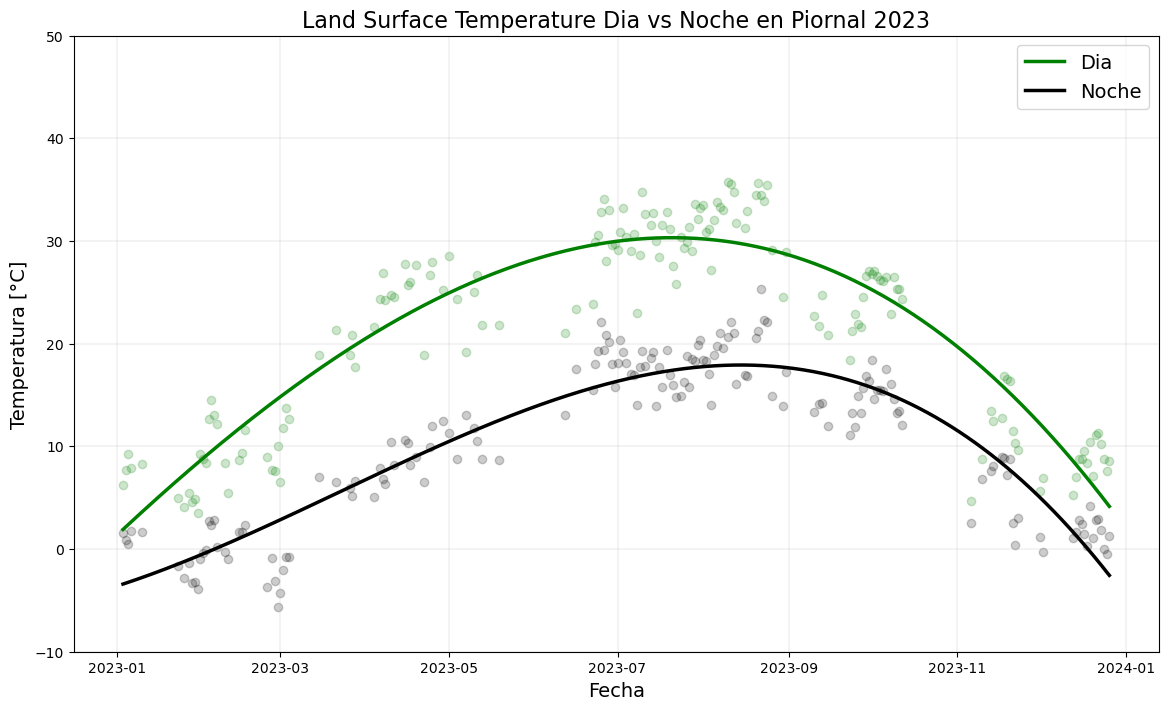

In [6]:
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

# Importar la colección MODIS para la temperatura del suelo
lst = ee.ImageCollection('MODIS/061/MOD11A1').select(['LST_Day_1km', 'LST_Night_1km'])

# Convertir a Celsius
def kelvin_to_celsius(img):
    day = img.select('LST_Day_1km').multiply(0.02).subtract(273.15)
    night = img.select('LST_Night_1km').multiply(0.02).subtract(273.15)
    return day.addBands(night).copyProperties(img, ["system:time_start"])

lst_celsius = lst.map(kelvin_to_celsius)

# Filtrar la colección para el año 2023
lst_anual = lst_celsius.filterDate('2023-01-01', '2023-12-31')

# Extraer la serie temporal anual
def get_time_series(collection, point):
    def create_feature(img):
        mean_dict = img.reduceRegion(ee.Reducer.mean(), point, scale=1000)
        return ee.Feature(None, {
            'date': img.date().format(),
            'LST_Day_1km': mean_dict.get('LST_Day_1km'),
            'LST_Night_1km': mean_dict.get('LST_Night_1km')
        })

    ts = collection.map(create_feature).filter(ee.Filter.neq('LST_Day_1km', None))
    return ts.getInfo()

time_series = get_time_series(lst_anual, u_poi)

# Convertir a DataFrame
dates = [f['properties']['date'] for f in time_series['features']]
day_temps = [f['properties']['LST_Day_1km'] for f in time_series['features']]
night_temps = [f['properties']['LST_Night_1km'] for f in time_series['features']]
df = pd.DataFrame({'Date': dates, 'Day Temperature': day_temps, 'Night Temperature': night_temps})
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Limpiar los datos eliminando NaNs
df = df.dropna()

# Definir la función de ajuste (polinomio de grado 3)
def fit_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Convertir las fechas a valores numéricos
x_data = (df.index - df.index[0]).days
y_data_day = df['Day Temperature'].values
y_data_night = df['Night Temperature'].values

# Ajustar la función a los datos de temperatura diurna
params_day, _ = optimize.curve_fit(fit_func, x_data, y_data_day)
# Ajustar la función a los datos de temperatura nocturna
params_night, _ = optimize.curve_fit(fit_func, x_data, y_data_night)

# Generar valores para la curva ajustada
x_fit = np.linspace(x_data.min(), x_data.max(), 500)
y_fit_day = fit_func(x_fit, *params_day)
y_fit_night = fit_func(x_fit, *params_night)

# Graficar con el estilo especificado
fig, ax = plt.subplots(figsize=(14, 8))

# Añadir puntos dispersos (scatter plot) para el día
ax.scatter(df.index, df['Day Temperature'], c='green', alpha=0.2)
# Añadir puntos dispersos (scatter plot) para la noche
ax.scatter(df.index, df['Night Temperature'], c='black', alpha=0.2)

# Añadir curva de ajuste para el día
ax.plot(df.index[0] + pd.to_timedelta(x_fit, unit='d'), y_fit_day,
        label='Dia', color='green', lw=2.5)

# Añadir curva de ajuste para la noche
ax.plot(df.index[0] + pd.to_timedelta(x_fit, unit='d'), y_fit_night,
        label='Noche', color='black', lw=2.5)

# Configurar parámetros del gráfico
ax.set_title(f'Land Surface Temperature Dia vs Noche en {Parcela} 2023', fontsize=16)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Temperatura [°C]', fontsize=14)
ax.set_ylim(-10, 50)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper right')

plt.show()


/var/folders/rp/pprjjvbn2gz018lk6d4k7kcr0000gn/T/ipykernel_1779/3706143027.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M').mean()


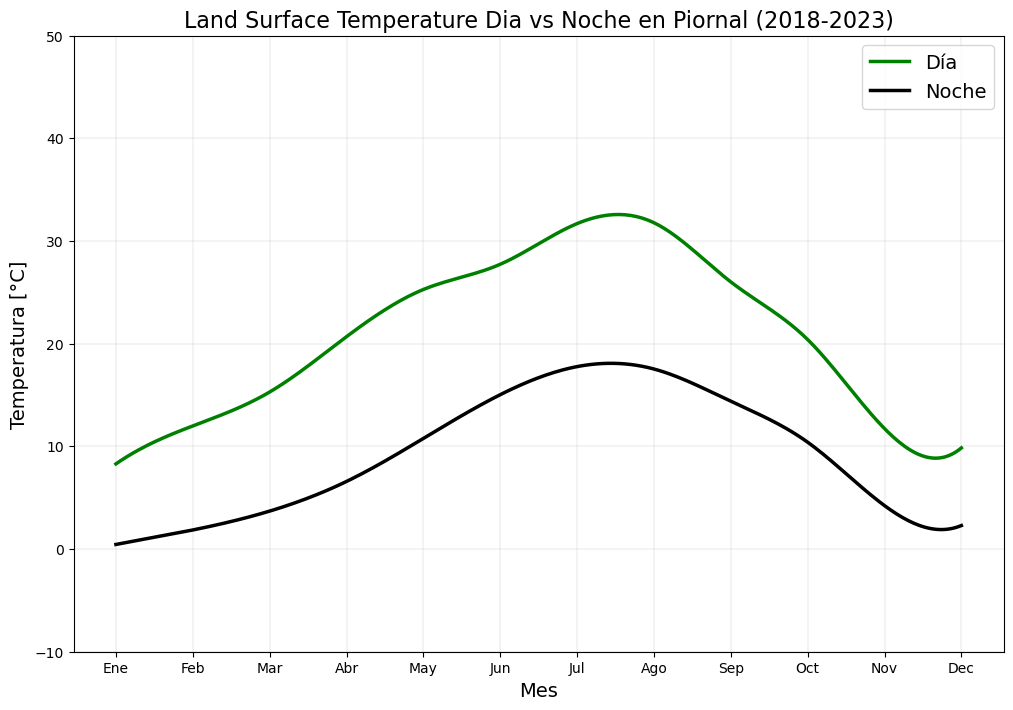

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate


# Definir la escala de muestreo
scale = 1000

# Fechas de los últimos 5 años
start_date = '2018-01-01'
end_date = '2023-12-31'

# Importar la colección MODIS para la temperatura del suelo
lst = ee.ImageCollection('MODIS/061/MOD11A1').select(['LST_Day_1km', 'LST_Night_1km'])

# Convertir a Celsius
def kelvin_to_celsius(img):
    day = img.select('LST_Day_1km').multiply(0.02).subtract(273.15)
    night = img.select('LST_Night_1km').multiply(0.02).subtract(273.15)
    return day.addBands(night).copyProperties(img, ["system:time_start"])

lst_celsius = lst.map(kelvin_to_celsius)

# Filtrar la colección para los últimos 5 años
lst_filtered = lst_celsius.filterDate(start_date, end_date)

# Extraer la serie temporal anual
def get_time_series(collection, point):
    def create_feature(img):
        mean_dict = img.reduceRegion(ee.Reducer.mean(), point, scale=1000)
        return ee.Feature(None, {
            'date': img.date().format(),
            'LST_Day_1km': mean_dict.get('LST_Day_1km'),
            'LST_Night_1km': mean_dict.get('LST_Night_1km')
        })

    ts = collection.map(create_feature).filter(ee.Filter.neq('LST_Day_1km', None))
    return ts.getInfo()

time_series = get_time_series(lst_filtered, u_poi)

# Convertir a DataFrame
dates = [f['properties']['date'] for f in time_series['features']]
day_temps = [f['properties']['LST_Day_1km'] for f in time_series['features']]
night_temps = [f['properties']['LST_Night_1km'] for f in time_series['features']]
df = pd.DataFrame({'Date': dates, 'Day Temperature': day_temps, 'Night Temperature': night_temps})
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Limpiar los datos eliminando NaNs
df = df.dropna()

# Agrupar por mes y calcular la media
monthly_means = df.resample('M').mean()

# Calcular la media mensual a lo largo de los 5 años
mean_monthly_day = monthly_means['Day Temperature'].groupby(monthly_means.index.month).mean()
mean_monthly_night = monthly_means['Night Temperature'].groupby(monthly_means.index.month).mean()

# Definir los meses
months = np.arange(1, 13)

# Crear una interpolación spline para suavizar las líneas
months_fine = np.linspace(1, 12, 300)
spl_day = interpolate.UnivariateSpline(months, mean_monthly_day, s=0.5)
spl_night = interpolate.UnivariateSpline(months, mean_monthly_night, s=0.5)

# Graficar con el estilo especificado
fig, ax = plt.subplots(figsize=(12, 8))

# Añadir puntos y curvas de ajuste para la temperatura diurna
ax.plot(months_fine, spl_day(months_fine), label='Día', color='green', lw=2.5)

# Añadir puntos y curvas de ajuste para la temperatura nocturna
ax.plot(months_fine, spl_night(months_fine), label='Noche', color='black', lw=2.5)

# Configurar parámetros del gráfico
ax.set_title(f'Land Surface Temperature Dia vs Noche en {Parcela} (2018-2023)', fontsize=16)
ax.set_xlabel('Mes', fontsize=14)
ax.set_ylabel('Temperatura [°C]', fontsize=14)
ax.set_xticks(months)
ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylim(-10, 50)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper right')

plt.show()


## Obtención de mapas

### Mapas interactivos

#### MDT:

In [8]:
import folium

# Importar la colección de elevación
elv = ee.Image('USGS/SRTMGL1_003')

# Hacer que los píxeles con elevación por debajo del nivel del mar sean transparentes
elv_img = elv.updateMask(elv.gt(0))

# Crear una zona de amortiguamiento de 10 km alrededor de Piornal
pior = u_poi.buffer(10000)  # metros

# Crear un mapa centrado en el punto de interés
map_center = [u_lat, u_lon]
m = folium.Map(location=map_center, zoom_start=12)

# Añadir la imagen de elevación al mapa
elv_mapid = elv_img.getMapId({
    'min': 350, 'max': 1800, 'region': pior, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
})
folium.TileLayer(
    tiles=elv_mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Elevation'
).add_to(m)

# Añadir el punto de interés al mapa
folium.Marker(
    location=map_center,
    popup=f'{Parcela}',
    icon=folium.Icon(color='red')
).add_to(m)

# Mostrar el mapa
m

#### pH del suelo

In [9]:
import folium

# Importar la colección de pH del suelo (0-5 cm profundidad)
ph_soil = ee.Image('OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02').select('b10')

# Hacer que los píxeles con valores de pH nulos sean transparentes
ph_soil_img = ph_soil.updateMask(ph_soil.neq(-9999))

# Crear una zona de amortiguamiento de 10 km alrededor de Piornal
pior = u_poi.buffer(10000)  # metros

# Crear un mapa centrado en el punto de interés
map_center = [u_lat, u_lon]
m = folium.Map(location=map_center, zoom_start=12)

# Añadir la imagen de pH del suelo al mapa
ph_mapid = ph_soil_img.getMapId({
    'min': 50, 'max': 90, 'palette': ['blue', 'green', 'red']
})
folium.TileLayer(
    tiles=ph_mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='pH del Suelo'
).add_to(m)

# Añadir el punto de interés al mapa
folium.Marker(
    location=map_center,
    popup=f'{Parcela}',
    icon=folium.Icon(color='red')
).add_to(m)

# Añadir una leyenda
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     ">
     &nbsp; <b>Leyenda: pH del Suelo </b> <br>
     &nbsp; <i style="background: blue"></i>&nbsp; Azul: 5 <br>
     &nbsp; <i style="background: green"></i>&nbsp; Verde: 7 <br>
     &nbsp; <i style="background: red"></i>&nbsp; Rojo: 9 <br>
     </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))

# Mostrar el mapa
m


#### Precipitaciones

In [10]:
import folium

# Definir los rangos de fechas para verano e invierno del 2023
start_date_summer = '2023-06-01'
end_date_summer = '2023-08-31'
start_date_winter = '2022-12-01'
end_date_winter = '2023-02-28'

# Cargar la colección de precipitación CHIRPS
chirps_collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').select('precipitation')

# Filtrar y sumar la precipitación total para el verano
summer_precipitation = chirps_collection.filterDate(start_date_summer, end_date_summer).sum()
winter_precipitation = chirps_collection.filterDate(start_date_winter, end_date_winter).sum()

# Crear una zona de amortiguamiento de 10 km alrededor de Piornal
buffer = u_poi.buffer(10000)  # metros

# Aplicar la máscara y recortar las imágenes a la zona de amortiguamiento
summer_precipitation = summer_precipitation.updateMask(summer_precipitation.neq(-9999))
winter_precipitation = winter_precipitation.updateMask(winter_precipitation.neq(-9999))

# Crear un mapa centrado en el punto de interés
map_center = [u_lat, u_lon]
m = folium.Map(location=map_center, zoom_start=8)

# Añadir la imagen de precipitación del verano al mapa
summer_mapid = summer_precipitation.getMapId({
    'min': 0, 'max': 500, 'palette': ['blue', 'green', 'yellow', 'red']
})
folium.TileLayer(
    tiles=summer_mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Precipitación Verano 2023'
).add_to(m)

# Añadir la imagen de precipitación del invierno al mapa
winter_mapid = winter_precipitation.getMapId({
    'min': 0, 'max': 800, 'palette': ['blue', 'green', 'yellow', 'red']
})
folium.TileLayer(
    tiles=winter_mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Precipitación Invierno 2022-2023'
).add_to(m)

# Añadir el punto de interés al mapa
folium.Marker(
    location=map_center,
    popup=f'{Parcela}',
    icon=folium.Icon(color='red')
).add_to(m)

# Añadir una leyenda
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 150px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     ">
     &nbsp; <b>Leyenda: Precipitación (mm) </b> <br>
     &nbsp; <i style="background: "blue""></i>&nbsp; 0-125 mm <br>
     &nbsp; <i style="background: "green""></i>&nbsp; 125-250 mm <br>
     &nbsp; <i style="background: yellow"></i>&nbsp; 250-375 mm <br>
     &nbsp; <i style="background: red"></i>&nbsp; 375-500 mm <br>
     </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))

# Añadir el control de capas
folium.LayerControl().add_to(m)

# Mostrar el mapa
m


#### NDVI y teselas de vegetación

In [11]:
import ee
import folium
from datetime import datetime

# Inicializar Earth Engine
ee.Initialize()

# Coordenadas del punto de interés
u_lon = -5.82441
u_lat = 40.10575
Parcela = "Piornal"
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Crear una zona de amortiguamiento de 10 km alrededor de Piornal
pior = u_poi.buffer(10000)  # metros

# Definir el rango de fechas para febrero y marzo del año actual
current_year = datetime.utcnow().year
start_date = f'{current_year}-02-01'
end_date = f'{current_year}-03-31'

# Convertir las fechas a formato de Earth Engine
start_date_ee = ee.Date(start_date)
end_date_ee = ee.Date(end_date)

# Cargar la colección de Sentinel-2
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(pior) \
    .filterDate(start_date_ee, end_date_ee) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# Obtener la imagen más reciente
recent_image = sentinel2.sort('system:time_start', False).first()

# Verificar si se obtuvo una imagen válida
if recent_image:
    # Verificar las bandas disponibles en la imagen reciente
    bandas = recent_image.bandNames().getInfo()
    print("Bandas disponibles en la imagen reciente:", bandas)

    # Asegurarse de que las bandas 'B8' y 'B4' estén presentes
    if 'B8' in bandas and 'B4' in bandas:
        # Calcular el NDVI
        ndvi = recent_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Aplicar una máscara para mantener solo valores NDVI > 0.5
        ndvi_masked = ndvi.updateMask(ndvi.gt(0.45))

        # Crear una imagen compuesta RGB (True color: B4, B3, B2)
        true_color = recent_image.select(['B4', 'B3', 'B2']).visualize(min=0, max=3000)

        # Crear un mapa centrado en el punto de interés
        map_center = [u_lat, u_lon]
        m = folium.Map(location=map_center, zoom_start=12)

        # Añadir la imagen Sentinel-2 RGB al mapa
        true_color_mapid = true_color.getMapId()
        folium.TileLayer(
            tiles=true_color_mapid['tile_fetcher'].url_format,
            attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
            overlay=True,
            name='Sentinel-2 RGB'
        ).add_to(m)

        # Añadir la imagen de NDVI enmascarada al mapa
        ndvi_mapid = ndvi_masked.getMapId({
            'min': 0.5, 'max': 1, 'palette': ['lightgreen', 'green', 'darkgreen']
        })
        folium.TileLayer(
            tiles=ndvi_mapid['tile_fetcher'].url_format,
            attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
            overlay=True,
            name='NDVI > 0.5'
        ).add_to(m)

        # Añadir el punto de interés al mapa
        folium.Marker(
            location=map_center,
            popup=f'{Parcela}',
            icon=folium.Icon(color='red')
        ).add_to(m)

        # Añadir el control de capas
        folium.LayerControl().add_to(m)

        # Mostrar el mapa
        display(m)
    else:
        print("Las bandas 'B8' y 'B4' no están disponibles en la imagen reciente.")
else:
    print("No se encontraron imágenes recientes en el rango de fechas especificado.")


/var/folders/rp/pprjjvbn2gz018lk6d4k7kcr0000gn/T/ipykernel_1779/925018046.py:18: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_year = datetime.utcnow().year


Bandas disponibles en la imagen reciente: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


### Descarga de mapas

In [12]:
# Crear un buffer de 50 km² alrededor del punto (aproximadamente un radio de 3.99 km para un área circular)
buffer = u_poi.buffer(3990).bounds()

# Definir las imágenes
srtm = ee.Image('USGS/SRTMGL1_003')
ph_soil = ee.Image('OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02').select('b10')
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate('2023-01-01', '2023-12-31').select('precipitation').sum()

# Definir el rango de fechas para febrero y marzo del año actual
current_year = datetime.utcnow().year
start_date = f'{current_year}-02-01'
end_date = f'{current_year}-03-31'
# Convertir las fechas a formato de Earth Engine
start_date_ee = ee.Date(start_date)
end_date_ee = ee.Date(end_date)
# Cargar la colección de Sentinel-2
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(buffer) \
    .filterDate(start_date_ee, end_date_ee) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    # Obtener la imagen más reciente
recent_image = sentinel2.sort('system:time_start', False).first()


# Obtener URLs de descarga
srtm_url = srtm.clip(buffer).getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'region': buffer
})

ph_soil_url = ph_soil.clip(buffer).getDownloadURL({
    'scale': 100,
    'crs': 'EPSG:4326',
    'region': buffer
})

chirps_url = chirps.clip(buffer).getDownloadURL({
    'scale': 50000,
    'crs': 'EPSG:4326',
    'region': buffer
})





# Verificar si se obtuvo una imagen válida
if recent_image:
    # Verificar las bandas disponibles en la imagen reciente
    bandas = recent_image.bandNames().getInfo()
    print("Bandas disponibles en la imagen reciente:", bandas)

    # Asegurarse de que las bandas 'B8' y 'B4' estén presentes
    if 'B8' in bandas and 'B4' in bandas:
        # Calcular el NDVI
        ndvi = recent_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Obtener URL de descarga para NDVI dentro del buffer
        ndvi_url = ndvi.clip(buffer).getDownloadURL({
            'scale': 10,
            'crs': 'EPSG:4326',
            'region': buffer
        })

        # Imprimir la URL de descarga para NDVI
        print('URL de descarga NDVI:', ndvi_url)
    else:
        print("Las bandas 'B8' y 'B4' no están disponibles en la imagen reciente.")
else:
    print("No se encontraron imágenes recientes en el rango de fechas especificado.")


# Imprimir las URLs de descarga
print('URL de descarga SRTM:', srtm_url)
print('URL de descarga pH del suelo:', ph_soil_url)
print('URL de descarga precipitación CHIRPS 2023:', chirps_url)

/var/folders/rp/pprjjvbn2gz018lk6d4k7kcr0000gn/T/ipykernel_1779/3161999536.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_year = datetime.utcnow().year


Bandas disponibles en la imagen reciente: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']
URL de descarga NDVI: https://earthengine.googleapis.com/v1/projects/ee-danielfv2208/thumbnails/69335428f942cc65f72bb34a9f7b5f8e-7eda54c0a17f55cf65f0975c130fec68:getPixels
URL de descarga SRTM: https://earthengine.googleapis.com/v1/projects/ee-danielfv2208/thumbnails/1f75f752da74f251dfd3d17d701160f6-0e4e1036d92b9855f8d8a119ce881372:getPixels
URL de descarga pH del suelo: https://earthengine.googleapis.com/v1/projects/ee-danielfv2208/thumbnails/d4276993a1ebde229b0625b7bdcdf8ef-b79e151a50819ece4d9e8e23286b0f40:getPixels
URL de descarga precipitación CHIRPS 2023: https://earthengine.googleapis.com/v1/projects/ee-danielfv2208/thumbnails/bebcbf7595b9644d164b99d6657d6307-cd21d29065a73c876a5cfa40700625f0:getPixels
